In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedrzee/top-selling-books-data2023-2025")

print("Path to dataset files:", path)

100%|██████████████████████████████████████| 5.77k/5.77k [00:00<00:00, 3.41MB/s]

Extracting files...
Path to dataset files: /Users/vivianwu/.cache/kagglehub/datasets/thedrzee/top-selling-books-data2023-2025/versions/1


In [59]:
#check what file was downloaded
import os

print(os.listdir(path))

['best sellin books 2023.csv']


In [60]:
import pandas as pd

file_path = os.path.join(path, 'best sellin books 2023.csv')  
df = pd.read_csv(file_path, encoding='latin1') #used a different encoding since it was giving me an error
df.head()

,id,Book name,Author,Rating,reviews count,form,price,Reading age,Print Length,Publishing date,Genre
0,#1,Atomic Habits: An Easy & Proven Way to Build G...,James Clear,4.8 out of 5 stars,145747,Hardcover,$18.88,NaN,320.0,16/10/2018,Self-Improvement
1,#2,"Iron Flame (Standard Edition) (The Empyrean, 2)",Rebecca Yarros,4.7 out of 5 stars,395512,Hardcover,$11.05,NaN,640.0,07/11/2023,Fiction & Action & Adventure
2,#3,Spare,Prince Harry The Duke of Sussex,4.5 out of 5 stars,116101,Hardcover,$11.99,NaN,416.0,"January 10, 2023",Biographies & Memoirs
3,#4,Fourth Wing,Rebecca Yarros,4.8 out of 5 stars,472618,Paperback,$13.62,NaN,544.0,17/09/2024,Fiction & Action & Adventure
4,#5,The Woman in Me,Britney Spears,4.4 out of 5 stars,51520,Hardcover,$11.37,NaN,288.0,"October 24, 2023",Biographies & Memoirs


In [61]:
# Handling Null Values
df['Print Length'].fillna(df['Print Length'].median(), inplace=True)
df['Print Length']

/var/folders/bk/m53r57sn6ds5pz41ww5w686m0000gn/T/ipykernel_56962/2980488509.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Print Length'].fillna(df['Print Length'].median(), inplace=True)


0     320.0
1     640.0
2     416.0
3     544.0
4     288.0
      ...  
95    192.0
96    224.0
97     84.0
98     40.0
99    272.0
Name: Print Length, Length: 100, dtype: float64

In [62]:
df['Reading age'].unique()

array([nan, '18 years and up', '1 - 2 years', '5 years and up',
       '8 years and up', 'baby and up', '7 years and up', '1 year and up',
       '3 - 4 years', '3 years and up', '2 years and up',
       '4 years and up', '12 years and up ', '9 years and up'],
      dtype=object)

In [63]:
# decided to just drop the reading age column since 70% of the data is missing
df = df.drop(columns=['Reading age'])

In [64]:
# inspect again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               100 non-null    object 
 1   Book name        100 non-null    object 
 2   Author           100 non-null    object 
 3   Rating           100 non-null    object 
 4   reviews count    100 non-null    int64  
 5   form             100 non-null    object 
 6   price            100 non-null    object 
 7   Print Length     100 non-null    float64
 8   Publishing date  100 non-null    object 
 9   Genre            100 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 7.9+ KB


In [65]:
# dropping id column as well since it's useless 
df = df.drop(columns = ['id'])

# converting some of the column types
df['price'] = df['price'].str.replace('[\$,]', '', regex=True).astype(float)

# Extract year as a usable numeric feature
df['publish_year'] = df['Publishing date'].str.extract(r'(\d{4})').astype(float)
df = df.drop(columns=['Publishing date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Book name      100 non-null    object 
 1   Author         100 non-null    object 
 2   Rating         100 non-null    object 
 3   reviews count  100 non-null    int64  
 4   form           100 non-null    object 
 5   price          100 non-null    float64
 6   Print Length   100 non-null    float64
 7   Genre          100 non-null    object 
 8   publish_year   100 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 7.2+ KB


**explanation**
According to ChatGPT, machine learning models cannot sort datetime objects, so I'm converting `publishing date` into floatfirst then extracting the year only ("ChatGPT", 5.2, 2026).

In [66]:
# standardizartion
from sklearn.preprocessing import StandardScaler

#list the columns that contain numbers, standardization only works on numbers.
numeric_cols = ['price', 'reviews count', 'Print Length', 'publish_year']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [67]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df[['form', 'Genre']])

#convert back into 2 columns
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['form', 'Genre']))

#drop the original columns
df = df.drop(columns=['form', 'Genre']).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = df[numeric_cols].columns
vif_data['VIF'] = [variance_inflation_factor(df[numeric_cols].values, i) 
                   for i in range(len(numeric_cols))]
print(vif_data)

         feature       VIF
0          price  1.586944
1  reviews count  1.084264
2   Print Length  1.658158
3   publish_year  1.080003


**explanation for Task 1**

- Dataset picked from [Kaggle](https://www.kaggle.com/datasets/thedrzee/top-selling-books-data2023-2025):  "Top Selling Books Data(2023-2025)"
- imported the data straight from Kaggle using Kagglehub
- convereted into Pandas dataframe to inspect
1. handling null values
   - using `.info()`, I can see the `Print length` and `Reading age` columns have missing values.
   - starting with `Print length` column, I filled it in with median
   - Moving on to `Reading age`, I decided to drop the entire column since 70% of the data is missing.
   - inspected again to make sure no null values exist
2. standardization
   - From `.info()`, I could see that some column types need to be changed so I worked on it before standarization.
   - Dropped column 0 `id` first, it's unecessary.
   - column `price` was an object, converted to float and removed `$`.
   - converted `publishing date` to float as well and only extracted the year.This way ML models can use it.
   - dropped `publishing date` column, no longer needed
3. One hot encoding
   - using category columns `form` and `genre`, since ML model cannot understand the categories such as paperback or hardcover.
   - encoding tool `encoder = OneHotEncoder(sparse_output=False, drop='first')`
   - using drop first since for `form`, it's either paperback or hardcover.
   - convert the 2 categories and save it in `encoded`
   - drop the orignial `form` and `genre` and add the encoded columns to the df
4.  Multicollinearity
   - first summarized what multicollinearity means with Claude: "Multicollinearity is when two or more of your features are highly correlated with each other — meaning one can be predicted from another"(Anthropic, 2026). The ML model gets confused if 2 features are too similar
   - Using VIF (Variance Inflation Factor) to decide which feature to remove
   - According to Claude, a VIF above 5 or 10 means the feature should be removed (Anthropic, 2026).
   - imported `VIF` from `statsmodels.stats.outliers_influence`
   - loop through each numerical column and calculate the score
   - result suggests the scores are all low, so there's no need to drop any features.

In [95]:
# task 2
from sklearn.datasets import load_svmlight_file

X, y = load_svmlight_file('farm-ads-vect')

**Since farm-ads-vect is already in SVMLight format (that feature:value sparse format), sklearn has a built-in loader for it**

In [96]:
# split into training and testing group
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# notes to myself
# Dimension Reduction — The Core Concept
# the dataset has hundreds of features (one per word). Most of them are probably useless or repetitive. 
#Dimension reduction compresses those hundreds of columns down to a smaller number while trying to keep the important
#patterns. Think of it like summarizing a 500 page book into 10 key points.

In [98]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

dimensions = [2, 5, 10, 20, 50, 100]

results = {'TruncatedSVD': [], 'NMF': [], 'LDA': []}

# TruncatedSVD
for d in dimensions:
    reducer = TruncatedSVD(n_components=d, random_state=42)
    X_train_r = reducer.fit_transform(X_train)
    X_test_r = reducer.transform(X_test)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_r, y_train)
    results['TruncatedSVD'].append(accuracy_score(y_test, clf.predict(X_test_r)))

# NMF (requires non-negative values)
X_train_nn = X_train.multiply(X_train > 0)  # ensure non-negative
X_test_nn = X_test.multiply(X_test > 0)
for d in dimensions:
    reducer = NMF(n_components=d, random_state=42, max_iter=500)
    X_train_r = reducer.fit_transform(X_train_nn)
    X_test_r = reducer.transform(X_test_nn)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_r, y_train)
    results['NMF'].append(accuracy_score(y_test, clf.predict(X_test_r)))

# LDA (max components = num_classes - 1, so only 1 here)
reducer = LDA()
X_train_r = reducer.fit_transform(X_train.toarray(), y_train)
X_test_r = reducer.transform(X_test.toarray())
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_r, y_train)
lda_acc = accuracy_score(y_test, clf.predict(X_test_r))

results

{'TruncatedSVD': [0.6212303980699638,
  0.7394451145958987,
  0.7708082026537998,
  0.7889022919179735,
  0.8082026537997588,
  0.8455971049457177],
 'NMF': [0.5404101326899879,
  0.752714113389626,
  0.7406513872135102,
  0.7913148371531966,
  0.7852834740651388,
  0.7889022919179735],
 'LDA': []}

In [99]:
print(lda_acc)

0.8805790108564535


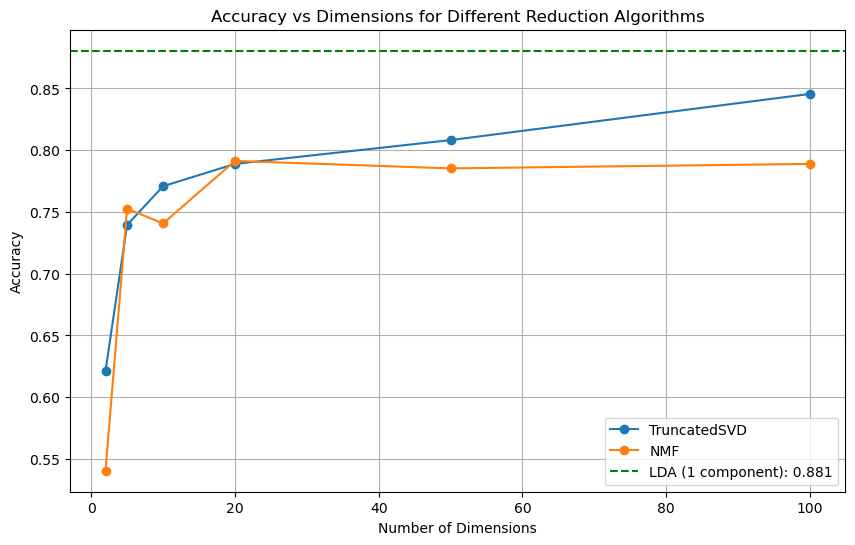

In [79]:
#plot
plt.figure(figsize=(10, 6))
for name in ['TruncatedSVD', 'NMF']:
    plt.plot(dimensions, results[name], marker='o', label=name)
plt.axhline(y=lda_acc, color='green', linestyle='--', label=f'LDA (1 component): {lda_acc:.3f}')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimensions for Different Reduction Algorithms')
plt.legend()
plt.grid(True)
plt.show()

**explanation for task 2**

- understanding the goal: shrinking the data without compromising accuracy.
- load the file with `load_svmlight_file` since the file is already in SVMLight format (feature:value sparse format), using built-in loader is easier
-  reads the file and automatically splits it into two things:
-  X — all the features (the word frequency numbers)
-  y — the labels (1 = farm ad, -1 = not a farm ad)
-  split data into training and testing set using `train_test_split` 80% training and 20% testing
-  using SVD, NMF, and LDA to run experiments on compressing the data as suggested by Claude.
-  dimensions we testing `[2, 5, 10, 20, 50, 100]` (trying to compress data into...)
-  created empty dictionary `results` to display all results later on
  1. SVD: designed for sparse data
     - loop through each number of dimensions
     - `fit_transform` trains and `transform` compresses the data
     - ` clf = LogisticRegression(max_iter=1000)` finds best solution in 1000 attempts
     - train on compressed data
     - append to result
   2. NMF: requires all values to be zero and above
      - loop through each dimesnsion
      - same process as SVD
   3. LDA: finds the best "angle" to view all data for optimial distance between groups.
      - `reducer = LDA()` creates LDA tool
- results:
    - for SVD: score increases as dimention increases (accuracy increase with dimension)
    - for NMF: score increase but doesn't change much after. Highest score with 20 dimensions.
    - for LDA: 0.88 accuracy, it performed better than SVD and NMF

- plot:
    - plot results for each dimension and their corresponding score
    - LDA only has 1 score so only one flat line.

In [110]:
# task 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# EEG Dataset
eeg = pd.read_csv('A001SV1_1.csv', header=1)  # skip metadata row
eeg.columns = ['COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 
                'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
eeg = eeg.apply(pd.to_numeric, errors='coerce').dropna()
print(eeg.shape)
print(eeg.head())

# Repeat Consumption Dataset
rcm = pd.read_csv('train.csv', header=None, names=['user_id', 'item_id', 'label'])
print(rcm.shape)
print(rcm.head())

(12287, 16)
   COUNTER  INTERPOLATED          AF3           F7           F3          FC5  \
0       98             0  4211.794769  4113.846053  4211.281948  4113.846053   
1       99             0  4222.051179  4125.128104  4211.281948  4120.512720   
2      100             0  4231.794768  4135.384514  4218.461435  4121.538361   
3      101             0  4221.538358  4132.820412  4214.358871  4124.102463   
4      102             0  4210.769128  4131.281950  4203.589641  4113.333233   

            T7           P7           O1           O2           P8  \
0  4234.358871  4215.384512  4204.102461  4151.794770  4213.846051   
1  4237.948614  4214.358871  4205.640923  4152.307591  4215.384512   
2  4217.948615  4216.922974  4214.871692  4156.922975  4216.410153   
3  4216.922974  4217.948615  4217.435794  4158.461437  4216.922974   
4  4243.076819  4214.358871  4212.820410  4153.333232  4213.846051   

            T8          FC6           F4           F8          AF4  
0  4239.999896  4

**explanation**

I started the task by asking Claude to explain the dataset to me, since it was confusing. According to its summary, - EEG dataset : "This is brainwave data recorded from a person wearing an EEG headset (Emotiv device). The headset has 14 electrodes placed on different parts of the scalp (AF3, F7, F3, FC5, T7, etc.), and it records electrical signals from the brain 128 times per second. Each row is one time snapshot, and each column is the voltage reading from one electrode" (Anthropic, 2026).
- Repeat Consumption dataset — "a completely different dataset about users consuming media items (like articles, videos, music etc.) and whether they came back to consume the same item again" (Anthropic, 2026).

- imported both datasets first with pandas and printed first few rows to inspect.

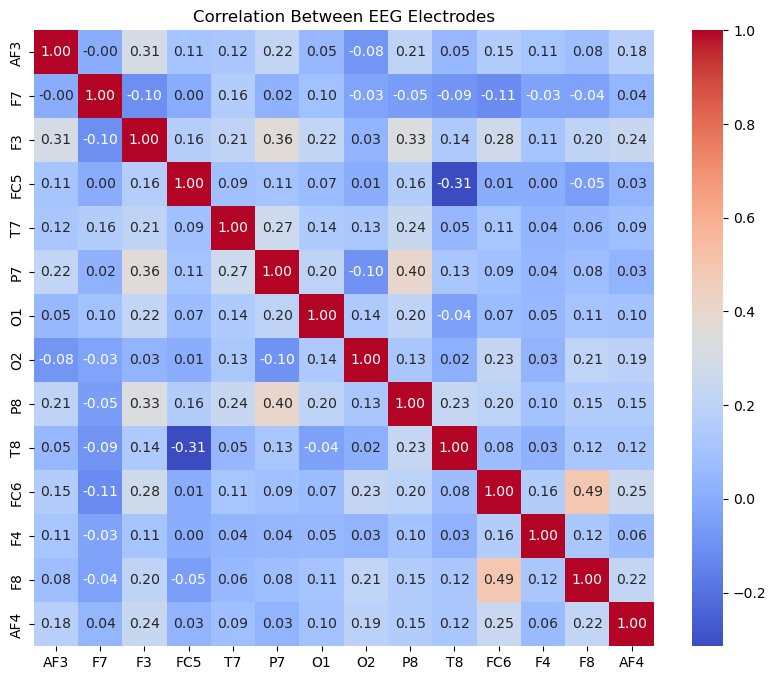

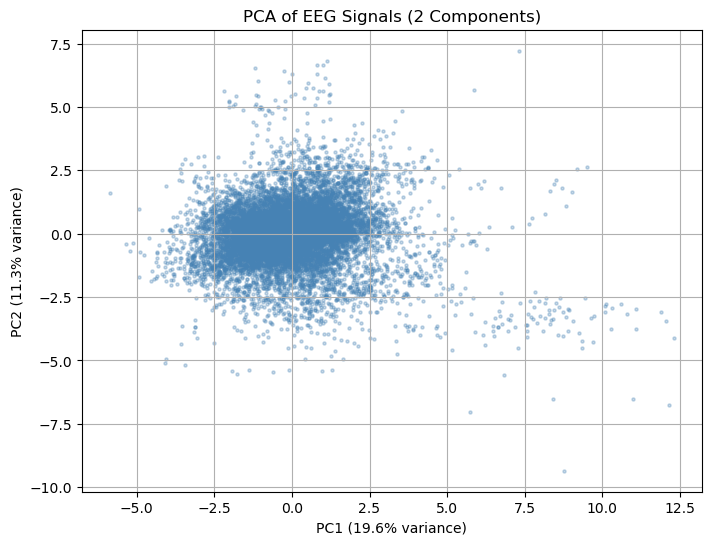

In [111]:
# EEG dataset visualization
# all electrode names
eeg_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Plot 1 - Correlation heatmap between electrodes
plt.figure(figsize=(10, 8))
#fmt = decimal places
sns.heatmap(eeg[eeg_channels].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Between EEG Electrodes')
plt.show()

# Plot 2 - scattergraph

scaler = StandardScaler()
eeg_scaled = scaler.fit_transform(eeg[eeg_channels])
pca = PCA(n_components=2)
eeg_pca = pca.fit_transform(eeg_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(eeg_pca[:, 0], eeg_pca[:, 1], alpha=0.3, s=5, color='steelblue')
plt.title('PCA of EEG Signals (2 Components)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.grid(True)
plt.show()

**explanation**

plot 1- heatmap
- suggested by claude to use seaborn for a heatmap.
- `eeg[eeg_channels].corr()` calculates the correlaiton
- X-axis and Y-axis: all 14 electrodes
- a grid that shows how correlated each electrode is.
- Dark red = move together
- dark blue = move opposite
  
Plot 2 - Scatter Graph
- There are 14 electrodes, but it is impossible to plot 14 dimensions, so PCA reduces it to 2D.
- X-axis: most variation in the data
- Y-axis: second most important pattern
- The higher the percentage, the more it matches the orignial 14 dimensions.

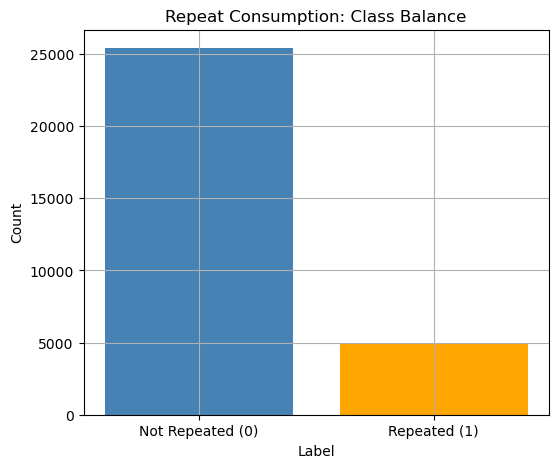

In [120]:
#plot 3 - class balance
rcm = pd.read_csv('train.csv', header=None, names=['user_id', 'item_id', 'consume_count'])
rcm['label'] = (rcm['consume_count'] > 1).astype(int)  # 1 if consumed more than once, 0 if only once
plt.figure(figsize=(6, 5))
counts = rcm['label'].value_counts().sort_index()
plt.bar(['Not Repeated (0)', 'Repeated (1)'], counts.values, color=['steelblue', 'orange'])
plt.title('Repeat Consumption: Class Balance')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()

**explanation**

plot 3
- load CSV again with new header
- create new column `label` to count repeated or not repeated
- plot 2 bars
- 1 if consumed more than once, 0 if only once
- result: most user interaction does not repeat.
- According to claude, this proves the data is not balanced.

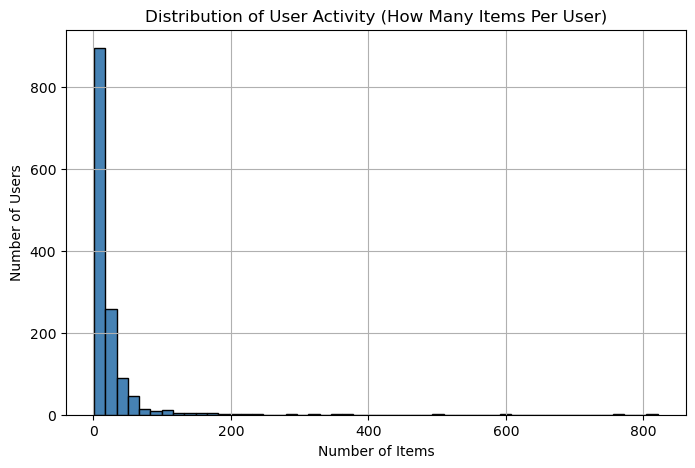

In [114]:
plt.figure(figsize=(8, 5))

#count how many time each user appear
user_counts = rcm['user_id'].value_counts()
plt.hist(user_counts.values, bins=50, color='steelblue', edgecolor='black')
plt.title('Distribution of User Activity (How Many Items Per User)')
plt.xlabel('Number of Items')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

**explanation**

plot 4- Distribution
- X-axis — number of items a user consumed
- Y-axis — how many users consumed that many items
- As shown in graph, most user only consume small number of items, as the number of items increases, the number of users drastically decreases

**Reference list:**

Anthropic. (2026). Claude (4.6) [Large language model]. https://claude.ai/